In [1]:
import os
import librosa
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, BatchNormalization, TimeDistributed,GlobalAveragePooling2D,Bidirectional,GRU,ConvLSTM2D
from sklearn.metrics import confusion_matrix, classification_report
from scipy.ndimage import zoom
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2

In [2]:
def resize_feature(feature, target_shape):
    """Resize a 2D feature array to a target shape (height, width)."""
    from scipy.ndimage import zoom
    zoom_factors = (
        target_shape[0] / feature.shape[0],
        target_shape[1] / feature.shape[1],
    )
    return zoom(feature, zoom_factors)    
def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_level * noise

def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate)

def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(audio, sr, n_steps=n_steps)

def apply_augmentation(audio, sr):
    aug_type = random.choice(["none", "noise", "stretch", "pitch"])
    if aug_type == "noise":
        return add_noise(audio)
    elif aug_type == "stretch":
        return time_stretch(audio)
    elif aug_type == "pitch":
        return pitch_shift(audio, sr)
    return audio
def extract_features(file_path, max_len=100, visualize=False, augment=False):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        if augment:
            audio = apply_augmentation(audio, sample_rate)

        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)

        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            chroma = np.pad(chroma, ((0, 0), (0, pad_width)), mode='constant')
            mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
            chroma = chroma[:, :max_len]
            mel = mel[:, :max_len]

        chroma_resized = resize_feature(chroma, (40, max_len))
        mel_resized = resize_feature(mel, (40, max_len))

        mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
        chroma_resized = (chroma_resized - np.mean(chroma_resized)) / np.std(chroma_resized)
        mel_resized = (mel_resized - np.mean(mel_resized)) / np.std(mel_resized)

        return np.stack([mfcc, chroma_resized, mel_resized], axis=-1)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [3]:
def build_cnn_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Flatten CNN output
    x = Flatten()(x)

    # Reshape to feed into LSTM: (time_steps=40, features=...)
    x = Reshape((40, -1))(x)

    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(32)(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# Example Usage (assuming you have loaded your data into X and y)

# 1. Load data (replace with your actual loading)
# Assuming X is a list of file paths and y is a list of labels
# Example (replace with your actual data loading):
# X = [ ... list of audio file paths ... ]
# y = [ ... list of emotion labels ... ]
X = []
y = []
ravdess_path = "C:\\Users\\Sanjeev\\Code\\RAVDESS DATASET"  

# Iterate through actors and files
for actor in os.listdir(ravdess_path):
    actor_path = os.path.join(ravdess_path, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            file_path = os.path.join(actor_path, file)
            if file.endswith(".wav"):
                X.append(file_path)

                # Extract label from filename (example, modify based on your filename structure)
                parts = file.split("-")
                emotion_code = int(parts[2])
                emotion_labels = {
                    1: "Angry",
                    2: "Happy",
                    3: "Sad",
                    4: "Neutral",
                    5: "Fear",
                    6: "Disgust",
                    # 'Angry', 'Happy', 'Sad', 'Neutral', 'Fear', 'Disgust'
                }
                emotion = emotion_labels.get(emotion_code, "unknown") # handles the cases of unexpected values in the dataset
                y.append(emotion)

# 2. Extract features
max_len = 100  # Define maximum length
X_features = []
for file_path in X:
    features = extract_features(file_path, max_len=max_len)
    if features is not None:
        X_features.append(features)
    else:
        print(f"Skipping {file_path} due to feature extraction error.")
        # Optionally remove the corresponding label from y as well

# Convert to numpy array
X = np.array(X_features)
print(X.shape)
# 3. Convert labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Fit and transform labels
num_classes = len(np.unique(y))    # Determine number of classes
y = to_categorical(y, num_classes=num_classes) # One-hot encode the labels
X, y = shuffle(X, y, random_state=42)
# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2




(1012, 40, 100, 3)


In [ ]:
# Build model
input_shape = (40, 100, 3)
model = build_cnn_lstm_model(input_shape, num_classes=6)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 100, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 100, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 40, 400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 40, 64)         │       119,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,734 (600.52 KB)

 Trainable params: 153,542 (599.77 KB)

 Non-trainable params: 192 (768.00 B)

In [6]:

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(np.argmax(y_train, axis=1)),
                                     y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
# 7. Train the model
history=model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=50,batch_size=32,verbose=1,class_weight=class_weights,callbacks=[early_stop])

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.1804 - loss: 1.8941 - val_accuracy: 0.2020 - val_loss: 1.8765
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.1795 - loss: 1.8543 - val_accuracy: 0.1872 - val_loss: 1.8744
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.1902 - loss: 1.8652 - val_accuracy: 0.1872 - val_loss: 1.8736
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.2419 - loss: 1.8828 - val_accuracy: 0.2118 - val_loss: 1.8705
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.2440 - loss: 1.8127 - val_accuracy: 0.2167 - val_loss: 1.8658
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.2613 - loss: 1.7638 - val_accuracy: 0.1724 - val_loss: 1.8668
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.2870 - loss: 1.7552 - val_accuracy: 0.1626 - val_loss: 1.8652
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.3016 - loss: 1.7136 - val_accuracy: 0

In [8]:
# 8. Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2133 - loss: 1.8429
Test Accuracy: 0.2216748744249344


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert one-hot encoded labels back to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


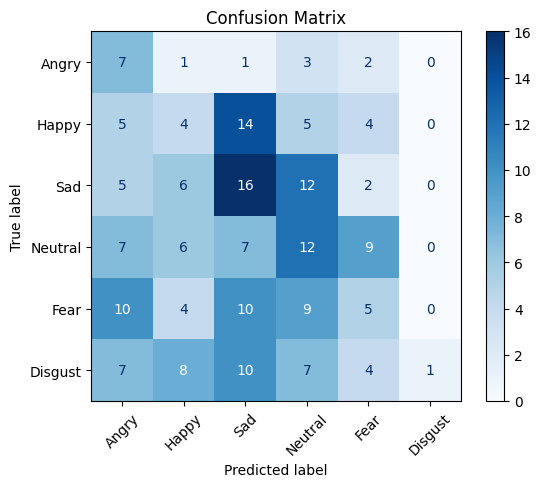

In [10]:
# Define your emotion class labels (edit as per your actual labels)
class_names = ['Angry', 'Happy', 'Sad', 'Neutral', 'Fear', 'Disgust']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred from earlier
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Angry       0.17      0.50      0.25        14
       Happy       0.14      0.12      0.13        32
         Sad       0.28      0.39      0.32        41
     Neutral       0.25      0.29      0.27        41
        Fear       0.19      0.13      0.16        38
     Disgust       1.00      0.03      0.05        37

    accuracy                           0.22       203
   macro avg       0.34      0.24      0.20       203
weighted avg       0.36      0.22      0.20       203



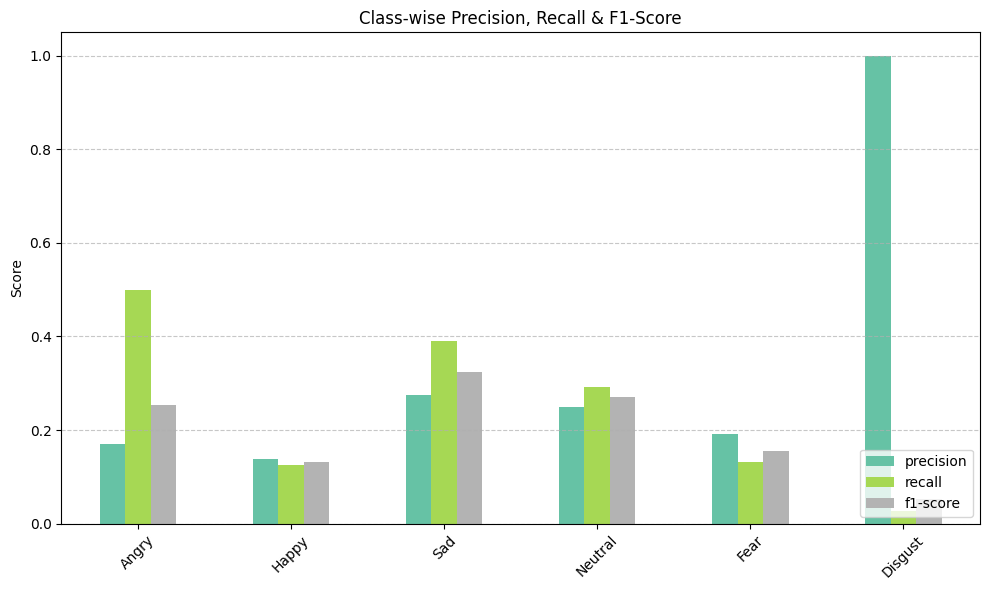

In [12]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Get the classification report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Convert to DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# Keep only emotion classes and relevant metrics
df_emotions = df_report.loc[class_names, ['precision', 'recall', 'f1-score']]

# Plot the bar chart
df_emotions.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("Class-wise Precision, Recall & F1-Score")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


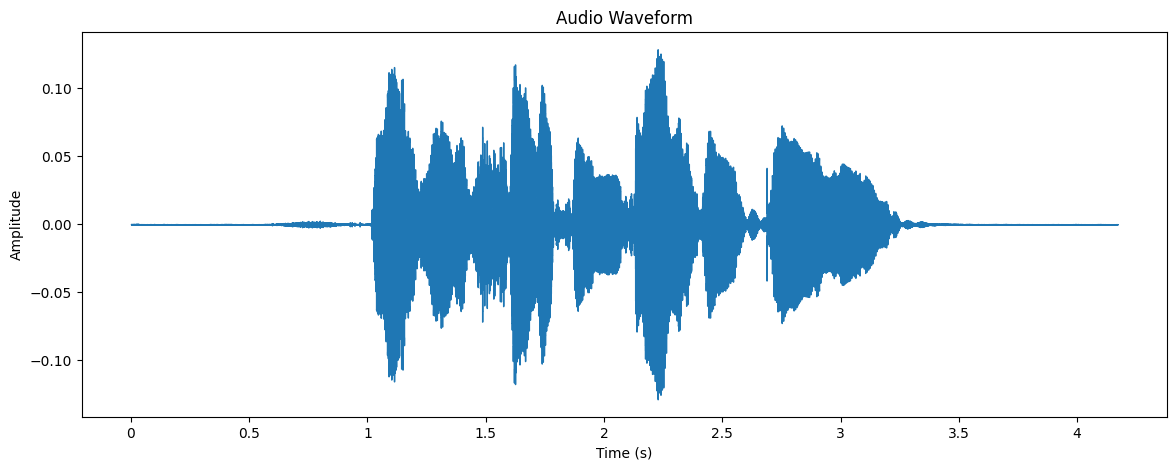

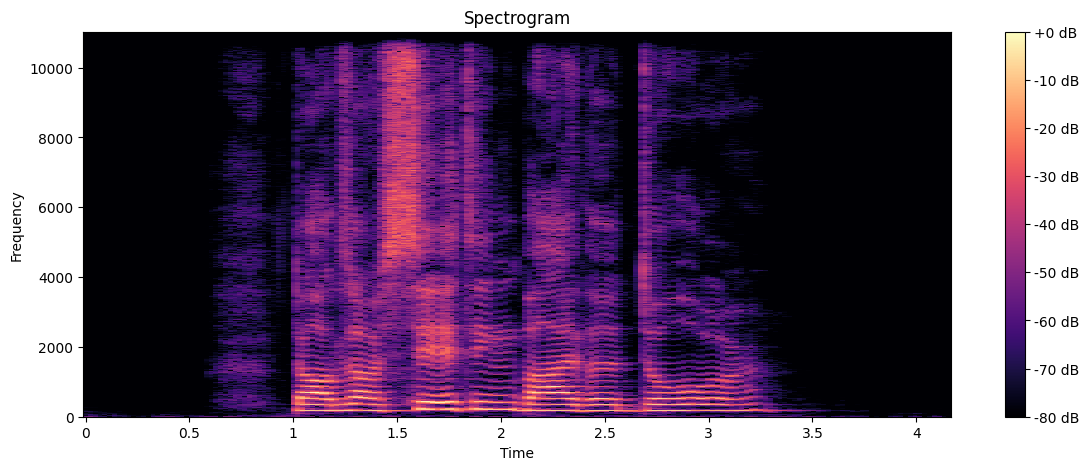

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Emotion: Disgust


In [22]:


new_audio = r"C:\Users\Sanjeev\Code\RAVDESS DATASET\Actor_11\03-02-06-01-02-02-11.wav"
features = extract_features(new_audio, visualize=True)
y, sr = librosa.load(new_audio)

# Plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot spectrogram (STFT)
D = librosa.stft(y)
DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

if features is not None:
    # Reshape to match model input: (1, 40, 100, 3)
    features_reshaped = features.reshape(1, 40, 100, 3)

    # Predict emotion
    prediction = model.predict(features_reshaped)
    predicted_emotion = label_encoder.inverse_transform([np.argmax(prediction)])

    print(f"Predicted Emotion: {predicted_emotion[0]}")
else:
    print("Feature extraction failed.")

